In [18]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Загружаем данные
housing = fetch_california_housing()
X, y = housing.data, housing.target

# Стандартизация данных
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

# Создание кастомного Dataset
class HousingDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Оборачиваем в DataLoader
train_dataset = HousingDataset(X_train, y_train)
test_dataset = HousingDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [19]:
import torch.nn as nn

class HousingModel(nn.Module):
    def __init__(self):
        super(HousingModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(8, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)  # Предсказание одной переменной (цена дома)
        )

    def forward(self, x):
        return self.network(x)

model = HousingModel()


In [20]:
# Функция потерь
criterion = nn.MSELoss()

# Оптимизаторы
optimizer_adam = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer_rmsprop = torch.optim.RMSprop(model.parameters(), lr=0.001)
optimizer_sgd = torch.optim.SGD(model.parameters(), lr=0.001)


In [21]:
def train_model_with_tracking(model, optimizer, train_loader, criterion, num_epochs=50):
    loss_history = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs).squeeze(1)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(train_loader)
        loss_history.append(epoch_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}')
    return loss_history

def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs).squeeze(1)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
    return test_loss / len(test_loader)


In [22]:
import matplotlib.pyplot as plt
# Визуализируем потери для каждого оптимизатора
def plot_loss_curves(epochs, loss_histories, labels):
    plt.figure(figsize=(10, 6))
    for loss_history, label in zip(loss_histories, labels):
        plt.plot(epochs, loss_history, label=label)

    plt.title('Training Loss Curves for Different Optimizers')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [23]:
# Функция для пересоздания новой модели
def create_model():
    return HousingModel()

# Создаем модель для каждого оптимизатора
model_adam = create_model()
model_rmsprop = create_model()
model_sgd = create_model()

# Тренируем модель и собираем данные по потерям для каждого оптимизатора
num_epochs = 50

# Adam
optimizer_adam = torch.optim.Adam(model_adam.parameters(), lr=0.001)
loss_history_adam = train_model_with_tracking(model_adam, optimizer_adam, train_loader, criterion, num_epochs=num_epochs)

# RMSProp
optimizer_rmsprop = torch.optim.RMSprop(model_rmsprop.parameters(), lr=0.001)
loss_history_rmsprop = train_model_with_tracking(model_rmsprop, optimizer_rmsprop, train_loader, criterion, num_epochs=num_epochs)

# SGD
optimizer_sgd = torch.optim.SGD(model_sgd.parameters(), lr=0.001)
loss_history_sgd = train_model_with_tracking(model_sgd, optimizer_sgd, train_loader, criterion, num_epochs=num_epochs)



Epoch 1/50, Loss: 1.1925090218871093
Epoch 2/50, Loss: 0.694603921091261
Epoch 3/50, Loss: 0.6359206759486317
Epoch 4/50, Loss: 0.5763058185823693
Epoch 5/50, Loss: 0.5431214325930461
Epoch 6/50, Loss: 0.5172514629758094
Epoch 7/50, Loss: 0.4941371748885833
Epoch 8/50, Loss: 0.4736110858680788
Epoch 9/50, Loss: 0.4772378164997771
Epoch 10/50, Loss: 0.46512599529559945
Epoch 11/50, Loss: 0.44516823742507905
Epoch 12/50, Loss: 0.4363411328763016
Epoch 13/50, Loss: 0.4478686973452568
Epoch 14/50, Loss: 0.43445275434531455
Epoch 15/50, Loss: 0.4300615328772009
Epoch 16/50, Loss: 0.43540664651423444
Epoch 17/50, Loss: 0.4219021982521065
Epoch 18/50, Loss: 0.41771857662141815
Epoch 19/50, Loss: 0.4281984763450859
Epoch 20/50, Loss: 0.41517876008571675
Epoch 21/50, Loss: 0.41405810354169736
Epoch 22/50, Loss: 0.408822366275078
Epoch 23/50, Loss: 0.4066744108707452
Epoch 24/50, Loss: 0.4074108508869636
Epoch 25/50, Loss: 0.4064001679913072
Epoch 26/50, Loss: 0.40799055814989343
Epoch 27/50, Lo

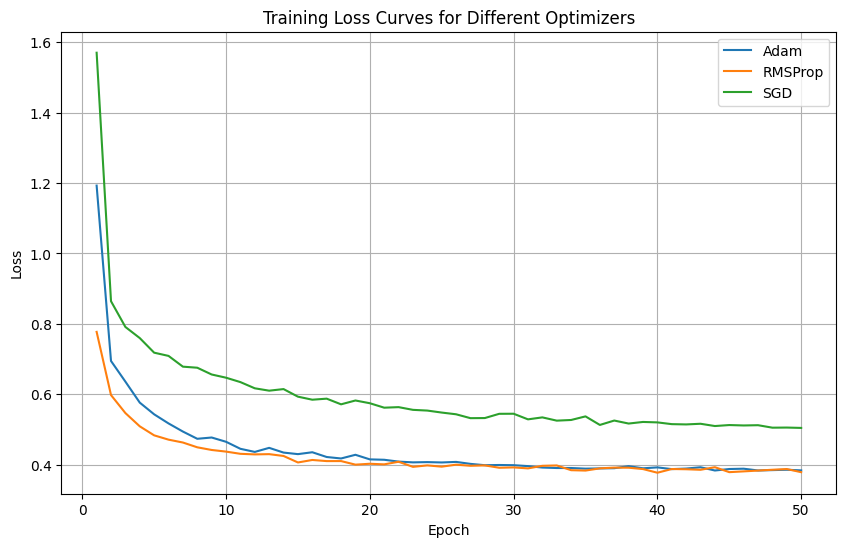

In [24]:
# Визуализируем
epochs = range(1, num_epochs + 1)
plot_loss_curves(epochs, [loss_history_adam, loss_history_rmsprop, loss_history_sgd], labels=['Adam', 'RMSProp', 'SGD'])

In [25]:
class HousingModelNoDropoutBN(nn.Module):
    def __init__(self):
        super(HousingModelNoDropoutBN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(8, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)  # Предсказание одной переменной (цена дома)
        )

    def forward(self, x):
        return self.network(x)


Epoch 1/50, Loss: 1.431562516068624
Epoch 2/50, Loss: 0.4962419194500308
Epoch 3/50, Loss: 0.4300434657734288
Epoch 4/50, Loss: 0.3966457131972983
Epoch 5/50, Loss: 0.379012186234155
Epoch 6/50, Loss: 0.3637028677034969
Epoch 7/50, Loss: 0.35656832934411103
Epoch 8/50, Loss: 0.34101660992980987
Epoch 9/50, Loss: 0.3284219672734087
Epoch 10/50, Loss: 0.3396070410212702
Epoch 11/50, Loss: 0.3158314356133958
Epoch 12/50, Loss: 0.3073340933000253
Epoch 13/50, Loss: 0.30178996070849995
Epoch 14/50, Loss: 0.2997147525268153
Epoch 15/50, Loss: 0.2990464771951526
Epoch 16/50, Loss: 0.29167608867499456
Epoch 17/50, Loss: 0.2934983940718095
Epoch 18/50, Loss: 0.3101647891843122
Epoch 19/50, Loss: 0.28946226361123
Epoch 20/50, Loss: 0.2854254759909693
Epoch 21/50, Loss: 0.2864377112551169
Epoch 22/50, Loss: 0.28571578472360104
Epoch 23/50, Loss: 0.28529573927733526
Epoch 24/50, Loss: 0.28162434407748466
Epoch 25/50, Loss: 0.2844521116372968
Epoch 26/50, Loss: 0.2779852318431228
Epoch 27/50, Loss:

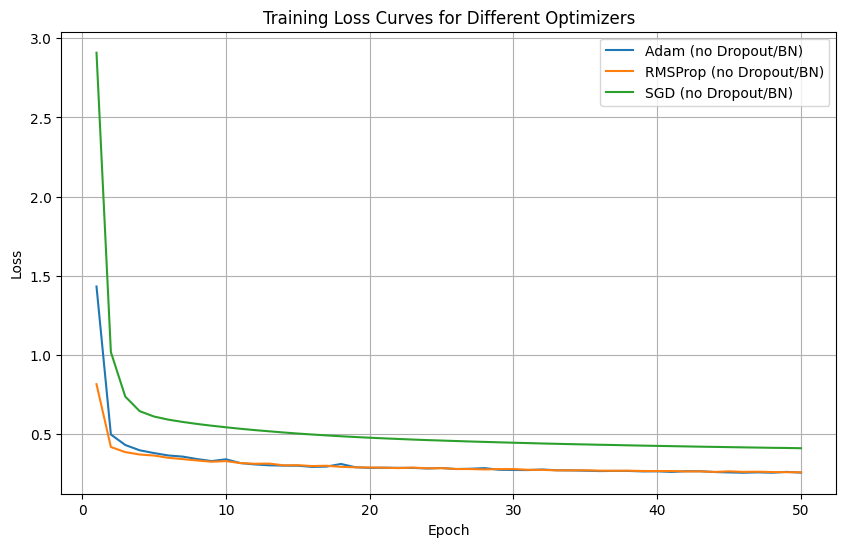

In [26]:
# Функция для пересоздания новой модели без Dropout и BatchNorm
def create_model_no_dropout_bn():
    return HousingModelNoDropoutBN()

# Создаем модель для каждого оптимизатора
model_adam_no_dropout_bn = create_model_no_dropout_bn()
model_rmsprop_no_dropout_bn = create_model_no_dropout_bn()
model_sgd_no_dropout_bn = create_model_no_dropout_bn()

# Тренируем модель и собираем данные по потерям для каждого оптимизатора
num_epochs = 50

# Adam без Dropout и BatchNorm
optimizer_adam_no_dropout_bn = torch.optim.Adam(model_adam_no_dropout_bn.parameters(), lr=0.001)
loss_history_adam_no_dropout_bn = train_model_with_tracking(model_adam_no_dropout_bn, optimizer_adam_no_dropout_bn, train_loader, criterion, num_epochs=num_epochs)

# RMSProp без Dropout и BatchNorm
optimizer_rmsprop_no_dropout_bn = torch.optim.RMSprop(model_rmsprop_no_dropout_bn.parameters(), lr=0.001)
loss_history_rmsprop_no_dropout_bn = train_model_with_tracking(model_rmsprop_no_dropout_bn, optimizer_rmsprop_no_dropout_bn, train_loader, criterion, num_epochs=num_epochs)

# SGD без Dropout и BatchNorm
optimizer_sgd_no_dropout_bn = torch.optim.SGD(model_sgd_no_dropout_bn.parameters(), lr=0.001)
loss_history_sgd_no_dropout_bn = train_model_with_tracking(model_sgd_no_dropout_bn, optimizer_sgd_no_dropout_bn, train_loader, criterion, num_epochs=num_epochs)

# Визуализация графиков потерь для каждой модели без Dropout и BatchNorm
plot_loss_curves(epochs,
                 [loss_history_adam_no_dropout_bn, loss_history_rmsprop_no_dropout_bn, loss_history_sgd_no_dropout_bn],
                 labels=['Adam (no Dropout/BN)', 'RMSProp (no Dropout/BN)', 'SGD (no Dropout/BN)'])


In [27]:
# Функция для тестирования модели на тестовой выборке
def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs).squeeze(1)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
    return test_loss / len(test_loader)


In [28]:
# Оценка моделей без Dropout и BatchNorm на тестовой выборке

# Adam без Dropout и BatchNorm
test_loss_adam_no_dropout_bn = evaluate_model(model_adam_no_dropout_bn, test_loader, criterion)
print(f'Test Loss (Adam without Dropout/BN): {test_loss_adam_no_dropout_bn}')

# RMSProp без Dropout и BatchNorm
test_loss_rmsprop_no_dropout_bn = evaluate_model(model_rmsprop_no_dropout_bn, test_loader, criterion)
print(f'Test Loss (RMSProp without Dropout/BN): {test_loss_rmsprop_no_dropout_bn}')

# SGD без Dropout и BatchNorm
test_loss_sgd_no_dropout_bn = evaluate_model(model_sgd_no_dropout_bn, test_loader, criterion)
print(f'Test Loss (SGD without Dropout/BN): {test_loss_sgd_no_dropout_bn}')


Test Loss (Adam without Dropout/BN): 0.2846119628276354
Test Loss (RMSProp without Dropout/BN): 0.2803499612175388
Test Loss (SGD without Dropout/BN): 0.4328403259501045


In [29]:
# Adam с Dropout и BatchNorm
test_loss_adam = evaluate_model(model_adam, test_loader, criterion)
print(f'Test Loss (Adam with Dropout/BN): {test_loss_adam}')

# RMSProp с Dropout и BatchNorm
test_loss_rmsprop = evaluate_model(model_rmsprop, test_loader, criterion)
print(f'Test Loss (RMSProp with Dropout/BN): {test_loss_rmsprop}')

# SGD с Dropout и BatchNorm
test_loss_sgd = evaluate_model(model_sgd, test_loader, criterion)
print(f'Test Loss (SGD with Dropout/BN): {test_loss_sgd}')


Test Loss (Adam with Dropout/BN): 0.33285231906690715
Test Loss (RMSProp with Dropout/BN): 0.526320297408987
Test Loss (SGD with Dropout/BN): 0.500034503362797


##**Выводы:**
Adam и RMSProp без Dropout и BatchNorm показывают лучшие результаты на тестовой выборке, чем их версии с Dropout/BatchNorm. Это может быть связано с тем, что модель без этих методов регуляризации более точно подстраивается под данные, так как Dropout исключает нейроны на этапе тренировки, а BatchNorm может сглаживать значения активаций. В некоторых случаях это может ухудшить обобщение.

SGD показывает наихудший результат как с Dropout/BatchNorm, так и без них, хотя версия без этих методов регуляризации демонстрирует лучшее качество. Это ожидаемо, так как SGD обычно требует более сложных механизмов регуляризации и более точного подбора гиперпараметров (например, уменьшения шага обучения).

####**Влияние Dropout и BatchNorm:**
Для этой задачи их использование ухудшило результаты, что может означать, что модель уже достаточно мала или данные хорошо подходят для решения задачи без необходимости в дополнительных методах регуляризации. Однако в более сложных или более крупных сетях Dropout и BatchNorm часто полезны для предотвращения переобучения и ускорения сходимости.